In [ ]:
#%%

import numpy as np 
import cv2 as cv
import os 
import torch 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import matplotlib.pyplot as plt


from glob import glob
from torch.utils.data import Dataset, DataLoader

In [ ]:
#%%

brain_tumor = 'D:/KULIAH/Semester 6/Pengenalan Pola/File Tugas/tugas besar/Brain Tumor Data Set/Brain Tumor'

brain_sehat = 'D:/KULIAH/Semester 6/Pengenalan Pola/File Tugas/tugas besar/Brain Tumor Data Set/Healthy'

In [ ]:
#%%

def ambil_data(folder):
    tumor = []
    dir_list = os.listdir(folder)
    for i in dir_list :
        data = cv.imread(folder + '/' + i)
        data = cv.resize(data,(300,300))
        data = data/255
        tumor.append(data)
    return tumor

In [ ]:
#%%

data_brtumor = np.array(ambil_data(brain_tumor))
data_brsehat = np.array(ambil_data(brain_sehat))

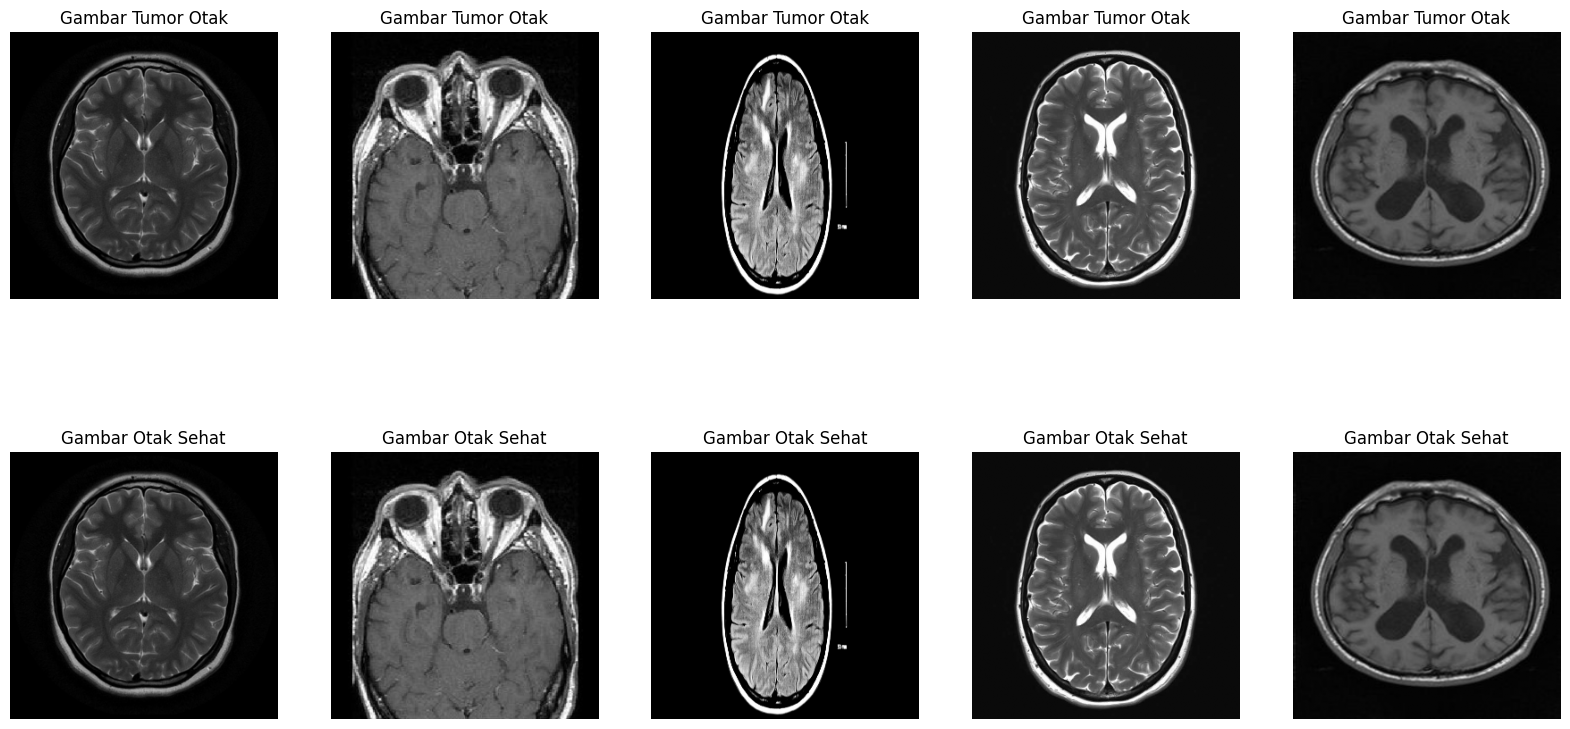

In [ ]:
#%%

fig, axes = plt.subplots(2, 5, figsize=(20,10))
for i in range(5):
    axes[0, i].imshow(data_brsehat[i])
    axes[0, i].set_title('Gambar Tumor Otak')
    axes[0, i].axis('off')
    
for i in range(5):
    axes[1, i].imshow(data_brsehat[i])
    axes[1, i].set_title('Gambar Otak Sehat')
    axes[1, i].axis('off')

plt.show()

In [ ]:
#%%

class TrajectoriesData(torch.utils.data.Dataset):
    def __init__(self, data):
        to1hot = np.eye(3)
        self.dataset = []
        for d, label in data:
            #print(d, label)
            self.dataset += [
                (im, to1hot[label]) for im in d
            ]
        #print(len(self.dataset))
    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, index:int) -> (np.ndarray, int):
            vec, label = self.dataset[index]
            return torch.tensor(vec, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [ ]:
#%%

train_data = torch.utils.data.DataLoader(TrajectoriesData([
    (data_brtumor[:16],0),
    (data_brsehat[:16],1)
    ]),batch_size=8,shuffle = True)
test_data = torch.utils.data.DataLoader(TrajectoriesData([
    (data_brtumor[16:],0),
    (data_brsehat[16:],1),
    ]),batch_size=8,shuffle = True)

In [ ]:
#%%

class CNNFormer(nn.Module):
    def __init__(self, feature_dim, dff=1024, num_head=1, num_layer=1, n_class=3, dropout=0.1, device='cpu'):
        super(CNNFormer, self).__init__()
        self.layer = num_layer
        self.conv = nn.Sequential(
            nn.Conv2d(feature_dim, 20, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 20, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 20, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 20, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(p=dropout),
    )

        # Hitung hidden_dim berdasarkan jumlah filter terbanyak
        self.hidden_dim = 20
        self.MHA = nn.MultiheadAttention(embed_dim=self.hidden_dim,num_heads=num_head, bias=False, dropout=dropout).to(device)
        self.feed_forward = nn.Sequential(
            nn.Linear(self.hidden_dim, dff),
            nn.ReLU(),
            nn.Linear(dff, self.hidden_dim)
        )
        self.norm = nn.LayerNorm(self.hidden_dim)
        # Sesuaikan dimensi lapisan linear
        self.lin_out = nn.Linear(self.hidden_dim * 256, n_class) #Ubah input size
    def forward(self, x):
        # Layer convolution
        x = self.conv(x)
        # Ubah dimensi tensor untuk sesuai dengan input multi-head  attention
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        # Layer transformer encoder
        for i in range(self.layer):
            y, _ = self.MHA(x, x, x)
            x = x + self.norm(y)
            y = self.feed_forward(x)
            x = x + self.norm(y)
            # Kembalikan dimensi ke format semula
            x = x.permute(0, 2, 1).view(batch_size, channels, height,
            width)
            # Ubah dimensi tensor untuk sesuai dengan lapisan linear
            x = x.reshape(batch_size, -1)
            # Layer linear output
            x = self.lin_out(x)
        return x

In [ ]:
#%%

model = CNNFormer(feature_dim = 3 )
model.to(device='cpu')
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion  = nn.CrossEntropyLoss()
EPOCH = 100
device = 'cpu'
loss_all = []
train_acc_all = []
val_acc_all = []

for epoch in range(EPOCH):
    loss_total = 0
    for batch, (src, trg) in enumerate(train_data):
        src = src.permute(0,3,1,2)
        pred = model(src).to(device)
        loss = criterion(pred, trg.to(device))
        loss_total+=loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_batch = loss_total / len(train_data)
    loss_all.append(loss_batch)
    print("epoch = ", epoch + 1, "loss = ", loss_batch)

epoch =  1 loss =  13.007491111755371
epoch =  2 loss =  10.936447203159332
epoch =  3 loss =  3.3250125646591187
epoch =  4 loss =  5.144630461931229
epoch =  5 loss =  3.787631034851074
epoch =  6 loss =  1.8517974317073822
epoch =  7 loss =  1.0779715776443481
epoch =  8 loss =  1.166461780667305
epoch =  9 loss =  1.2456074059009552
epoch =  10 loss =  0.9719210863113403
epoch =  11 loss =  0.7051835060119629
epoch =  12 loss =  0.7500483468174934
epoch =  13 loss =  0.9774453938007355
epoch =  14 loss =  1.1722158938646317
epoch =  15 loss =  1.1255927085876465
epoch =  16 loss =  0.6548825800418854
epoch =  17 loss =  0.6363174328580499
epoch =  18 loss =  0.3983236253261566
epoch =  19 loss =  0.19885931722819805
epoch =  20 loss =  0.0903212265111506
epoch =  21 loss =  0.00992251411662437
epoch =  22 loss =  0.01918085847137263
epoch =  23 loss =  0.9469818046782166
epoch =  24 loss =  0.006359876206261106
epoch =  25 loss =  0.022262448794208467
epoch =  26 loss =  0.09072668

In [ ]:
#%%

model.eval()
val_total_correct = 0
val_total_samples = 0
with torch.no_grad():
    for batch, (src, trg) in enumerate(test_data):
        src = src.permute(0, 3, 1, 2)
        pred = model(src).to(device)
        val_total_correct += (torch.argmax(pred, dim=1) == torch.argmax(trg, dim=1)).sum().item()
        val_total_samples += trg.size(0)

val_acc = val_total_correct / val_total_samples
val_acc_all.append(val_acc)
print("validation accuracy = ", val_acc)

validation accuracy =  0.703125


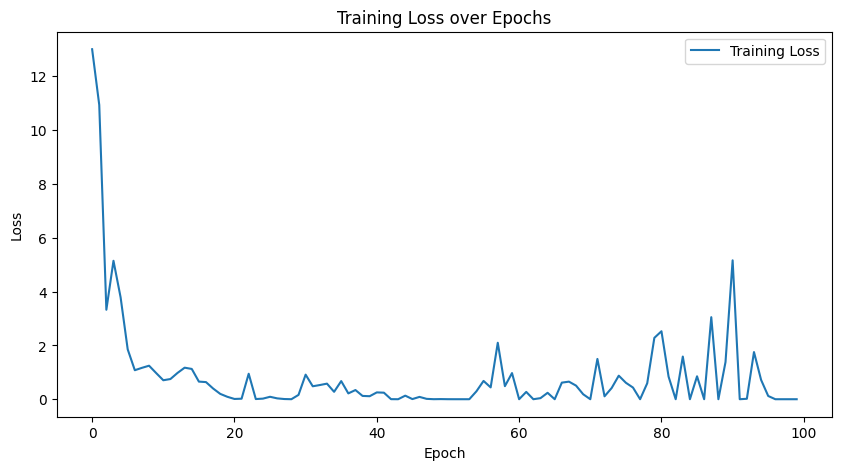

In [ ]:
#%%

plt.figure(figsize=(10, 5))
plt.plot(loss_all, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

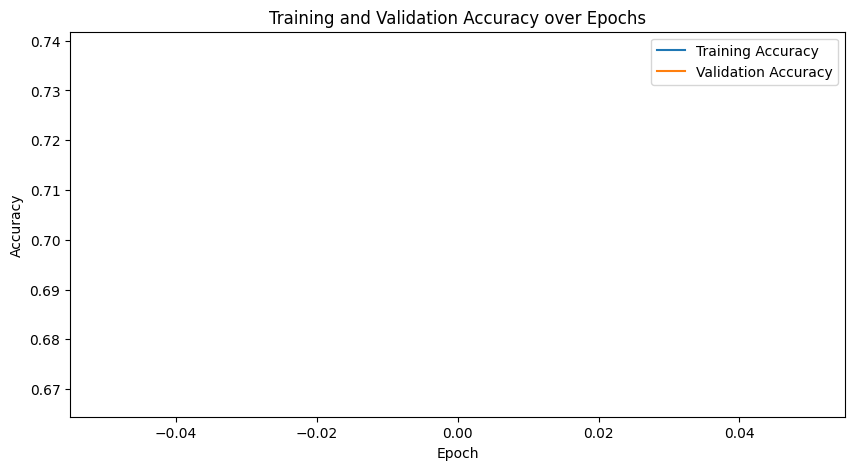

In [ ]:
#%%

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_all, label='Training Accuracy')
plt.plot(val_acc_all, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [ ]:
#%%

model.eval() #mode evaluasi
total_correct = 0
total_samples = 0
with torch.no_grad():
    for batch, (src, trg) in enumerate(test_data):
        src = src.permute(0, 3, 1, 2)
        # Forward pass
        pred = model(src).to(device)
        # Hitung jumlah prediksi yang benar
        total_correct += (torch.argmax(pred, dim=1) == torch.argmax(trg, dim=1)).sum().item()
        total_samples += trg.size(0)
accuracy = total_correct / total_samples
print(f'Test sample: ', total_samples)
print(f'Test correct: ', total_correct)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test sample:  320
Test correct:  225
Test Accuracy: 70.31%
